In [113]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython import display
from collections import Counter
import optuna
import wandb

In [114]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [115]:
# Hyperparameters
learning_rate = 0.01
gamma = 0.99
epsilon = 0.1

In [116]:
# Environment setup
env = gym.make('FrozenLake-v1', is_slippery=False)
n_actions = env.action_space.n
n_states = env.observation_space.n

In [117]:
# Neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(n_states, n_actions)

    def forward(self, x):
        return self.fc(x)

In [118]:
# Initialize model, optimizer, and loss function
device = torch.device("mps")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [119]:
def objective(trial):
    wandb.init(project="optuna_hyperparameter_optimization", 
           name=f"trial_{trial.number}", 
           config=trial.params)

    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    gamma = trial.suggest_float('gamma', 0.8, 0.9999)
    epsilon_start = trial.suggest_float('epsilon_start', 0.1, 0.9)
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.99, 0.9999)
    
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Training loop
    # Initialize lists to store metrics
    losses = []
    weight_norms = []
    bias_norms = []
    grad_norms = []
    total_rewards = []
    epsilon_values = []
    episode_lengths = []
    successful_episodes = 0
    success_rate = []
    
    plot_update_frequency = 30  # Update plots every 50 episodes, adjust as needed
    num_episodes = 300
    # Training loop
    epsilon = epsilon_start

    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0
        episode_length = 0
    
    
        while not done:
            state_tensor = torch.FloatTensor(np.eye(n_states)[int(state)]).to(device)
            q_values = model(state_tensor)
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = torch.argmax(q_values).item()
            
            # (0, 0.0, False, False, {'prob': 1.0})
            next_state, reward, done, _, _ = env.step(action)
    
            next_state_tensor = torch.FloatTensor(np.eye(n_states)[next_state]).to(device)
            next_q_values = model(next_state_tensor)
    
            max_next_q = torch.max(next_q_values)
            q_target = reward + gamma * max_next_q * (1 - done)
            q_val = q_values[action]
    
            loss = loss_fn(q_val.view(1).cpu(), torch.tensor([q_target]))
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            state = next_state
    
            # Calculate and store loss
            losses.append(loss.item())
    
            # Calculate and store weight and bias norms
            weight_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() > 1)
            bias_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() == 1)
            weight_norms.append(weight_norm.item())
            bias_norms.append(bias_norm.item())
    
            # Calculate and store gradient norms
            grad_norm = sum(torch.norm(param.grad)**2 for param in model.parameters() if param.grad is not None)
            grad_norms.append(grad_norm.item())
            
            # Accumulate reward
            total_reward += reward
            # Increment episode length
            episode_length += 1
    
            if done and reward > 0:  # Assuming a positive reward indicates success
                successful_episodes += 1
    
    
        # Store total reward and epsilon value for the episode
        total_rewards.append(total_reward)
        epsilon_values.append(epsilon)
        episode_lengths.append(episode_length)
        success_rate.append(successful_episodes / (episode + 1))  # Calculate success rate
    
    
    
        # Decay epsilon
        if epsilon > 0.01:
            epsilon *= epsilon_decay
    
        # Update plots at specified frequency
        if episode % plot_update_frequency == 0 or episode == num_episodes - 1:
            # log metrics to wandb
            wandb.log({"loss": loss.item(),
                       "weight_norm": weight_norm.item(),
                       "bias_norm": bias_norm.item(),
                       "grad_norm": grad_norm.item(),
                       "total_reward": total_reward,
                       "epsilon": epsilon,
                       "episode_length": episode_length,
                       "success_rate": successful_episodes / (episode + 1)})
            if False:
                # Plotting
                display.clear_output(wait=True)
                plt.figure(figsize=(15, 20))  # Adjust the figure size as needed
                
                # Subplot for Loss
                plt.subplot(4, 2, 1)
                plt.plot(losses)
                plt.title('Loss')
                
                # Subplot for Weight Norms
                plt.subplot(4, 2, 2)
                plt.plot(weight_norms)
                plt.title('Weight Norms')
                
                # Subplot for Bias Norms
                plt.subplot(4, 2, 3)
                plt.plot(bias_norms)
                plt.title('Bias Norms')
                
                # Subplot for Gradient Norms
                plt.subplot(4, 2, 4)
                plt.plot(grad_norms)
                plt.title('Gradient Norms')
                
                # Subplot for Total Rewards
                plt.subplot(4, 2, 5)
                plt.plot(total_rewards)
                plt.title('Total Rewards')
                
                # Subplot for Epsilon Values
                plt.subplot(4, 2, 6)
                plt.plot(epsilon_values)
                plt.title('Epsilon Values')
                
                # Subplot for Episode Lengths
                plt.subplot(4, 2, 7)
                plt.plot(episode_lengths)
                plt.title('Episode Lengths')
                
                # Subplot for Success Rate
                plt.subplot(4, 2, 8)
                plt.plot(success_rate)
                plt.title('Success Rate')
                
                plt.tight_layout()
                display.display(plt.gcf())
                plt.close()
    
    # Close the environment
    env.close()
        # Ensure the W&B run finishes with the trial
    wandb.finish()
    # Return the metric you want to optimize
    # For example, the average success rate
    return sum(success_rate) / len(success_rate)


In [120]:

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-12-25 23:16:04,281] A new study created in memory with name: no-name-5acd7785-e309-4176-9427-27b979871fd1


bias_norm,█▁▃▆█
episode_length,█▃▂▁▁
epsilon,█▆▄▃▁
grad_norm,▁▂█▁▂
loss,▁▂█▁▂
success_rate,▁▃▄▆█
total_reward,▁▁█▁▁
weight_norm,█▆▃▃▁
bias_norm,0.10029
episode_length,5
epsilon,0.29552


[I 2023-12-25 23:16:27,251] Trial 0 finished with value: 0.12796662757680324 and parameters: {'learning_rate': 0.03767756179511895, 'gamma': 0.8020938554845787, 'epsilon_start': 0.6154812050342213, 'epsilon_decay': 0.9982932666540032}. Best is trial 0 with value: 0.12796662757680324.


bias_norm,▁▇██▃▆▄▅▄▇▄
episode_length,▁▁▂▂▁▃▃▁█▃▁
epsilon,█▇▆▆▅▄▃▃▂▂▁
grad_norm,▁▂▂▁▁▁▁▁▆█▅
loss,▁▂▂▁▁▁▁▁▆█▅
success_rate,▁▅▄▆▅▆▇▇▇██
total_reward,▁▁▁▁▁██▁▁▁▁
weight_norm,▁▄▄▅▅▅▅█▄▅▆
bias_norm,0.30438
episode_length,4
epsilon,0.36869


[I 2023-12-25 23:16:40,447] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 1.1624474055308792e-05, 'gamma': 0.9528753283711036, 'epsilon_start': 0.3790573677053474, 'epsilon_decay': 0.9968805464419709}. Best is trial 0 with value: 0.12796662757680324.


bias_norm,█▇▇▆▅▄▄▃▂▂▁
episode_length,▁██▁▅▁▁▅▁▁▁
epsilon,█▇▆▅▄▄▃▂▂▁▁
grad_norm,█▇▆▆▅▄▄▃▂▂▁
loss,█▇▆▆▅▄▄▃▂▂▁
success_rate,▁▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁▁
weight_norm,█▇▇▆▅▄▄▃▂▂▁
bias_norm,0.07159
episode_length,3
epsilon,0.14847


[I 2023-12-25 23:17:02,532] Trial 2 finished with value: 0.14066288775690605 and parameters: {'learning_rate': 0.00295910180082949, 'gamma': 0.9672540580429354, 'epsilon_start': 0.43193307368144274, 'epsilon_decay': 0.9995040547317204}. Best is trial 2 with value: 0.14066288775690605.


bias_norm,▁▁▁▁▂▆█████
episode_length,█▁█▁▃▄▃▆▂▄▇
epsilon,█▇▇▆▅▄▄▃▂▂▁
grad_norm,█▁▁▁▁▁▁▂▁▁▁
loss,█▁▁▁▁▁▁▂▁▁▁
success_rate,▁▁▁▁▂▄▅▆▇▇█
total_reward,▁▁▁▁▁█▁▁▁██
weight_norm,▂▁▁▁▂▅▇████
bias_norm,1.36893
episode_length,14
epsilon,0.37221


[I 2023-12-25 23:17:27,461] Trial 3 finished with value: 0.020230375187966394 and parameters: {'learning_rate': 0.0011307891149950162, 'gamma': 0.9515386116320353, 'epsilon_start': 0.5097231626909285, 'epsilon_decay': 0.999790565769824}. Best is trial 2 with value: 0.14066288775690605.


bias_norm,█▁▂▃▅▇▆▅▄▄▆
episode_length,▃▄▂▂▃▂▃▇█▁▃
epsilon,█▇▇▆▅▄▄▃▂▂▁
grad_norm,█▁▁▁▂▁▁▁▁▁▁
loss,█▁▁▁▂▁▁▁▁▁▁
success_rate,▁▁▁▁▇▇▇▆▆▇█
total_reward,▁▁▁▁▁▁▁▁▁▁▁
weight_norm,█▇▆▅▄▃▂▂▁▁▁
bias_norm,0.05358
episode_length,10
epsilon,0.47868


[I 2023-12-25 23:17:53,996] Trial 4 finished with value: 0.16833328407964757 and parameters: {'learning_rate': 0.003812889451556125, 'gamma': 0.984854846034387, 'epsilon_start': 0.34845995156085857, 'epsilon_decay': 0.999262479284262}. Best is trial 4 with value: 0.16833328407964757.


bias_norm,▁▁▁▂▂▆██▇▇█
episode_length,▁█▁▃▅▁▁▂▂▂▂
epsilon,█▇▆▆▅▄▄▃▂▂▁
grad_norm,█▁▁▁▅▆▁▁▁▂▄
loss,█▁▁▁▅▆▁▁▁▂▄
success_rate,▁▂▁▂▂▃▅▆▇██
total_reward,▁▁▁▁█▁▁██▁▁
weight_norm,▁▁▁▁▂▄▅▆▇▇█
bias_norm,1.61347
episode_length,8
epsilon,0.27927


[I 2023-12-25 23:18:27,787] Trial 5 finished with value: 0.006936925521592787 and parameters: {'learning_rate': 7.669023814528631e-05, 'gamma': 0.8569210858579668, 'epsilon_start': 0.3608413821052196, 'epsilon_decay': 0.9961601004706376}. Best is trial 4 with value: 0.16833328407964757.


bias_norm,█▇▇▆▅▄▃▃▂▁▁
episode_length,▄▂▂▁▂▃▃▁█▁▁
epsilon,█▇▆▅▄▄▃▂▂▁▁
grad_norm,▁▁█▁▇▆▅▄▄▃▃
loss,▁▁█▁▇▆▅▄▄▃▃
success_rate,▁▁█▆▅▄▃▃▃▃▂
total_reward,▁▁▁▁▁▁▁▁▁▁▁
weight_norm,█▇▇▆▆▅▄▃▂▂▁
bias_norm,0.02143
episode_length,2
epsilon,0.11378


[I 2023-12-25 23:18:42,503] Trial 6 finished with value: 0.00518445168352967 and parameters: {'learning_rate': 0.00015798437043685934, 'gamma': 0.8789772376386791, 'epsilon_start': 0.7874231676855163, 'epsilon_decay': 0.9979771559821932}. Best is trial 4 with value: 0.16833328407964757.


bias_norm,█▇▆▅▄▄▃▃▂▂▁
episode_length,▆▃▅▃▃▂▆▁█▂▁
epsilon,█▇▆▅▅▄▃▃▂▂▁
grad_norm,▄█▄▆▄▄▄▃▃▃▁
loss,▄█▄▆▄▄▄▃▃▃▁
success_rate,▁▁▁▁▁▁▆█▇▆▆
total_reward,▁▁▁▁▁▁▁▁▁▁▁
weight_norm,█▇▇▆▅▄▄▂▂▁▁
bias_norm,0.05535
episode_length,2
epsilon,0.42893


[I 2023-12-25 23:19:01,958] Trial 7 finished with value: 0.575047441646383 and parameters: {'learning_rate': 0.026514591365969876, 'gamma': 0.8251724707269791, 'epsilon_start': 0.3207237971056019, 'epsilon_decay': 0.9935894352887233}. Best is trial 7 with value: 0.575047441646383.


bias_norm,▁█▆▆▆▇▅▅▇▆▄
episode_length,▂▅▁▂▅▂▂█▄▂▂
epsilon,█▇▅▄▄▃▂▂▂▁▁
grad_norm,█▂▃▃▁▁▁▁▁▁▁
loss,█▂▃▃▁▁▁▁▁▁▁
success_rate,▁▄▅▆▆▇▇▇███
total_reward,▁█▁████████
weight_norm,▁▆▆▇▇▇▇▇▇██
bias_norm,0.26919
episode_length,6
epsilon,0.04658


[I 2023-12-25 23:19:29,047] Trial 8 finished with value: 0.06897942023920943 and parameters: {'learning_rate': 0.0014318917347635818, 'gamma': 0.8570685261279455, 'epsilon_start': 0.44424582336257484, 'epsilon_decay': 0.9961387975538833}. Best is trial 7 with value: 0.575047441646383.


bias_norm,▂▁▁▁▁▁▁▂▄██
episode_length,▇▁▂▁█▂▁▃▂▂▂
epsilon,█▇▆▅▄▄▃▂▂▁▁
grad_norm,▁▁▁▁▁█▁▃▁▁▁
loss,▁▁▁▁▁█▁▃▁▁▁
success_rate,▁▁▁▁▁▂▂▃▅▇█
total_reward,▁▁▁▁▁█▁████
weight_norm,▃▂▂▁▁▁▁▂▅▇█
bias_norm,0.42061
episode_length,6
epsilon,0.13918


[I 2023-12-25 23:19:56,529] Trial 9 finished with value: 0.010649950290566859 and parameters: {'learning_rate': 0.0007027824737301788, 'gamma': 0.9405072789340383, 'epsilon_start': 0.21424544431557513, 'epsilon_decay': 0.9988180839003865}. Best is trial 7 with value: 0.575047441646383.


bias_norm,█▆▅▃▃▂▂▁▁▁▂
episode_length,▁▁▁▁█▃▃▂▂▁▁
epsilon,█▇▆▆▅▄▃▃▂▂▁
grad_norm,▃▂▁▁▂▁▁▁▁▁█
loss,▃▂▁▁▂▁▁▁▁▁█
success_rate,▁▁▁▁▁▁▆▆▆▆█
total_reward,▁▁▁▁▁▁▁▁▁▁█
weight_norm,██▇▇▆▄▃▂▂▁▁
bias_norm,0.01883
episode_length,6
epsilon,0.15026


[I 2023-12-25 23:20:18,079] Trial 10 finished with value: 0.5140767367182631 and parameters: {'learning_rate': 0.09443371833289117, 'gamma': 0.8258516946061312, 'epsilon_start': 0.10348841158569533, 'epsilon_decay': 0.9923619019244012}. Best is trial 7 with value: 0.575047441646383.


bias_norm,▁▃█▇▅▃▂▁▅▅▅
episode_length,▂▁█▂▂▂▂▂▂▂▂
epsilon,█▆▅▄▃▃▂▂▁▁▁
grad_norm,▁▂▁▁█▁▁▁▁▁▁
loss,▁▂▁▁█▁▁▁▁▁▁
success_rate,▁▁▃▅▆▇▇▇███
total_reward,▁▁██▁██████
weight_norm,▁▃█▇▅▅▅▅▅▅▅
bias_norm,0.47525
episode_length,6
epsilon,0.01037


[I 2023-12-25 23:20:48,067] Trial 11 finished with value: 0.19255148267390368 and parameters: {'learning_rate': 0.07396391795418569, 'gamma': 0.8013584417181296, 'epsilon_start': 0.14161031565038806, 'epsilon_decay': 0.9919783177593924}. Best is trial 7 with value: 0.575047441646383.


bias_norm,▁▁▇▄▅▂▆█▅█▄
episode_length,▄█▁▂▄▁▁▆▂▁▁
epsilon,█▆▅▄▃▃▂▂▁▁▁
grad_norm,▁█▂▂▁▁▁▂▁▁▁
loss,▁█▂▂▁▁▁▂▁▁▁
success_rate,▁▁▁▂▂▃▅▆▆▇█
total_reward,▁▁▁█▁▁█████
weight_norm,▁▃▅▇███▇█▇▇
bias_norm,0.64688
episode_length,6
epsilon,0.01264


[I 2023-12-25 23:21:09,875] Trial 12 finished with value: 0.1896276950347512 and parameters: {'learning_rate': 0.01718091621145993, 'gamma': 0.8315483409361514, 'epsilon_start': 0.10804835514275568, 'epsilon_decay': 0.9928469023356977}. Best is trial 7 with value: 0.575047441646383.


bias_norm,▂▁▁▁▁▅▆██▇▇
episode_length,▁▁▁▁▁▆█▆▆▆▆
epsilon,█▆▅▄▃▃▂▂▁▁▁
grad_norm,█▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁
success_rate,▁▁▁▁▁▃▄▆▇▇█
total_reward,▁▁▁▁▁██████
weight_norm,▁▁▁▁▁██▆▆▆▇
bias_norm,0.46607
episode_length,6
epsilon,0.01254


[I 2023-12-25 23:21:38,140] Trial 13 finished with value: 0.15587789747203804 and parameters: {'learning_rate': 0.01504696593883335, 'gamma': 0.8959691758144748, 'epsilon_start': 0.2549170565158625, 'epsilon_decay': 0.9938275376556036}. Best is trial 7 with value: 0.575047441646383.


bias_norm,▁▁▁▁▁▆██▇▇█
episode_length,█▄▇▃▇▂▁▂▂▂▂
epsilon,█▇▅▄▄▃▂▂▂▁▁
grad_norm,█▁▂▁▁▁▁▁▁▁▁
loss,█▁▂▁▁▁▁▁▁▁▁
success_rate,▁▁▁▁▁▂▄▅▆▇█
total_reward,▁▁▁▁▁█▁████
weight_norm,▂▁▂▂▂▆▆█▇██
bias_norm,0.78707
episode_length,6
epsilon,0.03978


[I 2023-12-25 23:21:58,120] Trial 14 finished with value: 0.45810791211999363 and parameters: {'learning_rate': 0.012330046095073965, 'gamma': 0.8380599901856739, 'epsilon_start': 0.24792398685214218, 'epsilon_decay': 0.9900646654259951}. Best is trial 7 with value: 0.575047441646383.


bias_norm,▁▁▂▅▇▆▇▇█▇█
episode_length,▄█▁▁▁▁▁▁▁▁▁
epsilon,█▆▅▄▃▂▂▂▁▁▁
grad_norm,▁▁█▁▁▁▁▁▁▁▁
loss,▁▁█▁▁▁▁▁▁▁▁
success_rate,▁▁▂▄▅▆▇▇▇██
total_reward,▁▁█████████
weight_norm,▂▁▃▆▆▇▇███▇
bias_norm,0.45983
episode_length,6
epsilon,0.0124


[I 2023-12-25 23:22:31,394] Trial 15 finished with value: 0.014436798284145406 and parameters: {'learning_rate': 0.09143647373970176, 'gamma': 0.8270106039112651, 'epsilon_start': 0.5779644020813133, 'epsilon_decay': 0.9913420599490912}. Best is trial 7 with value: 0.575047441646383.


bias_norm,▃▂█▅▃▂▄▁▁▁▃
episode_length,█▁▁▁▄▇▁▆▁▆▁
epsilon,█▆▅▄▃▂▂▂▁▁▁
grad_norm,▁█▃▁▅▁▁▁▁▁▁
loss,▁█▃▁▅▁▁▁▁▁▁
success_rate,▁▁▁▄▇▆█▇▆▆▅
total_reward,▁▁▁▁▁▁▁▁▁▁▁
weight_norm,▁▅▄▅█▆▆▅▄▄▆
bias_norm,0.51602
episode_length,2
epsilon,0.04256


[I 2023-12-25 23:22:51,629] Trial 16 finished with value: 0.17004990588523794 and parameters: {'learning_rate': 0.0070538571592181545, 'gamma': 0.9056843267712962, 'epsilon_start': 0.8729160577799076, 'epsilon_decay': 0.9946682483480175}. Best is trial 7 with value: 0.575047441646383.


bias_norm,▂▁▁▁▂▆█████
episode_length,▃▂█▁▁▃▃▃▄▃▂
epsilon,█▇▆▅▄▃▃▂▂▁▁
grad_norm,█▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁
success_rate,▁▁▁▁▂▃▅▅▇▇█
total_reward,▁▁▁▁▁████▁▁
weight_norm,▃▂▁▁▂▅▇▇▇██
bias_norm,0.89298
episode_length,3
epsilon,0.17557


[I 2023-12-25 23:23:20,015] Trial 17 finished with value: 0.3738443217809422 and parameters: {'learning_rate': 0.03559638612253314, 'gamma': 0.9201766634110826, 'epsilon_start': 0.18456437818389468, 'epsilon_decay': 0.9935134534675142}. Best is trial 7 with value: 0.575047441646383.


bias_norm,▁▁▂▇▁██▅█▃▅
episode_length,▆▅█▁▃▁▁▁▁▁▁
epsilon,█▇▅▄▄▃▂▂▂▁▁
grad_norm,▁▁▁▁█▁▁▁▁▁▁
loss,▁▁▁▁█▁▁▁▁▁▁
success_rate,▁▁▁▃▄▆▇▇▇██
total_reward,▁▁▁█▁██████
weight_norm,▁▃█▇▅▆▆▆▅█▇
bias_norm,0.23495
episode_length,6
epsilon,0.0262


[I 2023-12-25 23:23:43,900] Trial 18 finished with value: 0.20351390555882654 and parameters: {'learning_rate': 0.03700718577502639, 'gamma': 0.86664272240422, 'epsilon_start': 0.26593042883636964, 'epsilon_decay': 0.9911849708516292}. Best is trial 7 with value: 0.575047441646383.


bias_norm,▁▂▄▃▆▄█▆▃▂▃
episode_length,▂▄█▄▂▇▇▇▁▇▇
epsilon,█▆▅▄▃▂▂▂▁▁▁
grad_norm,▁▂▆▁█▁▁▁▁▃▁
loss,▁▂▆▁█▁▁▁▁▃▁
success_rate,▁▁▁▁▂▄▆▇█▇█
total_reward,▁▁▁▁▁███▁██
weight_norm,▁▄▆▆▅▆▅▆██▇
bias_norm,0.17609
episode_length,6
epsilon,0.01867


[I 2023-12-25 23:24:03,517] Trial 19 finished with value: 0.14750303508703683 and parameters: {'learning_rate': 0.00026897074569312806, 'gamma': 0.8211080871980361, 'epsilon_start': 0.6886336243723618, 'epsilon_decay': 0.9945866920259149}. Best is trial 7 with value: 0.575047441646383.


Best trial:
 Value: 0.575047441646383
 Params: 
    learning_rate: 0.026514591365969876
    gamma: 0.8251724707269791
    epsilon_start: 0.3207237971056019
    epsilon_decay: 0.9935894352887233


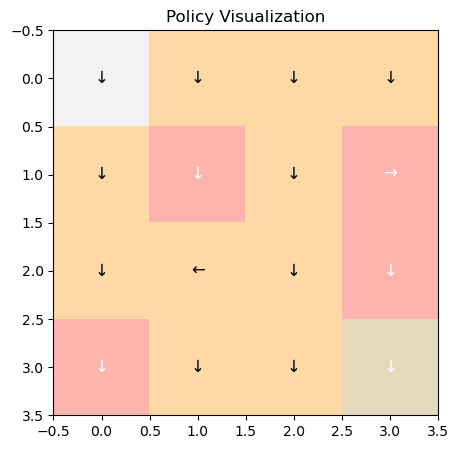

In [121]:
# Convert env.desc to a string format
desc = env.desc.astype(str)

# Create a color map for the grid
color_map = {'S': 1.0, 'F': 0.5, 'H': 0.0, 'G': 0.75}
grid_colors = np.vectorize(color_map.get)(desc)

# Extracting the policy from the model
policy = np.array([torch.argmax(model(torch.FloatTensor(np.eye(env.observation_space.n)[s]).to(device))).item() for s in range(env.observation_space.n)])

# Mapping actions to symbols for visualization
action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
policy_symbols = np.vectorize(action_symbols.get)(policy)

# Reshape for grid visualization
policy_grid = policy_symbols.reshape(env.desc.shape)

# Plotting the policy grid
plt.figure(figsize=(5, 5))
plt.imshow(grid_colors, cmap='Pastel1', interpolation='nearest')
for i in range(desc.shape[0]):
    for j in range(desc.shape[1]):
        cell_color = 'white' if desc[i, j] in ['H', 'G'] else 'black'
        plt.text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=12, color=cell_color)
plt.title('Policy Visualization')
plt.show()

In [122]:
env.desc


array([[b'S', b'F', b'F', b'F'],
       [b'F', b'H', b'F', b'H'],
       [b'F', b'F', b'F', b'H'],
       [b'H', b'F', b'F', b'G']], dtype='|S1')

In [123]:
def analyze_failures(env, model, num_episodes=100):
    failed_states = []
    for _ in range(num_episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = torch.argmax(model(torch.FloatTensor(np.eye(env.observation_space.n)[state]).to(device))).item()
            next_state, reward, done, _, _ = env.step(action)
            if done and reward == 0:  # Check if the episode ended without success
                failed_states.append(state)
            state = next_state
    return failed_states

# Analyze failures
failed_states = analyze_failures(env, model)
print("Failure States: ", set(failed_states))

Failure States:  {8}


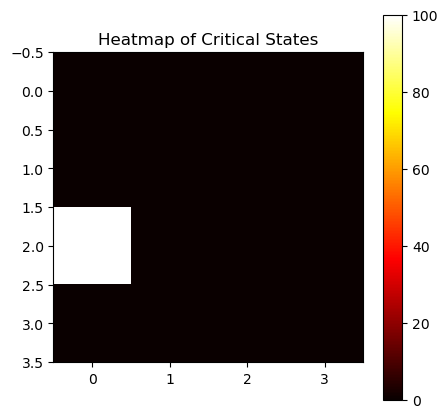

In [124]:
def plot_heatmap(env, state_counts):
    grid_counts = np.zeros(env.desc.shape)
    for state, count in state_counts.items():
        x, y = np.unravel_index(state, env.desc.shape)
        grid_counts[x, y] = count

    plt.figure(figsize=(5, 5))
    plt.imshow(grid_counts, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Heatmap of Critical States')
    plt.show()

# Count occurrences of each state in failure cases
state_counts = Counter(failed_states)

# Plot heatmap
plot_heatmap(env, state_counts)
